In [1]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-06 15:18:30,458 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020']).filter_within_geometry(sierras)

In [8]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-05 17:41:12,314 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-05 17:41:12,612 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-05 17:41:13,714 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-05 17:41:14,036 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-05 17:41:14,197 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [148]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-05 21:47:53,055 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-05 21:47:53,735 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-05 21:47:56,593 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-05 21:47:57,530 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-05 21:47:57,882 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

In [122]:
creek_fire = sierra_firep.get_fire('CREEK')

In [129]:
matches = gedi_matching.match_measurements_before_and_after_fire(creek_fire, gedi_burned, 'agbd')

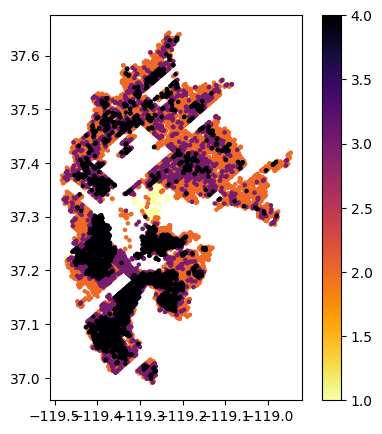

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
geo_plot(matches, ax, 'burn_severity_median', vmin=1, vmax=4)

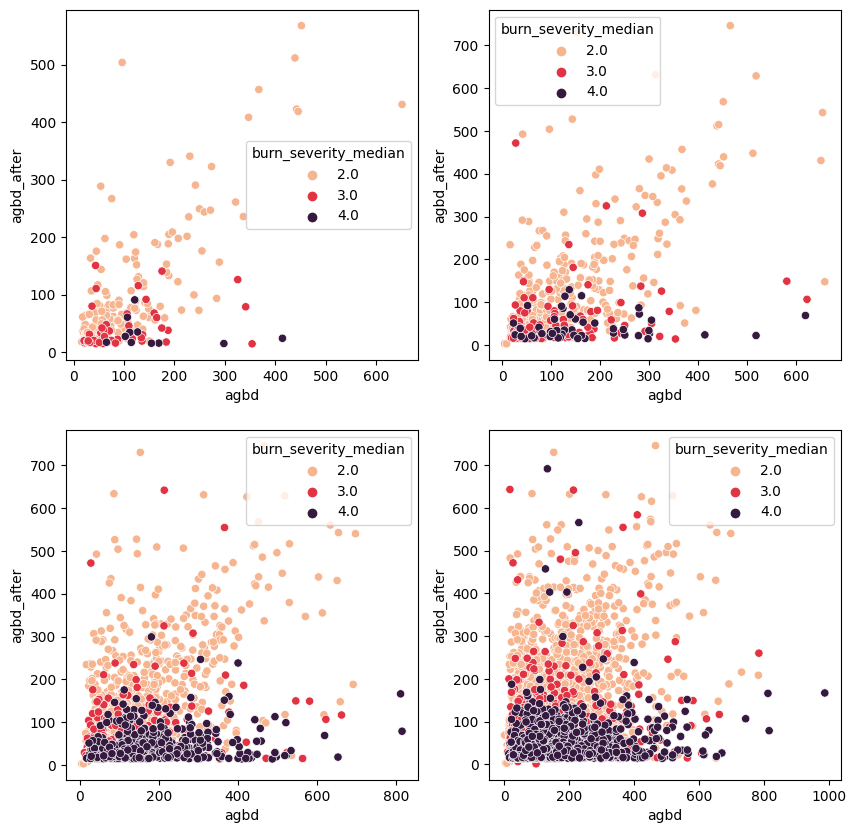

In [55]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


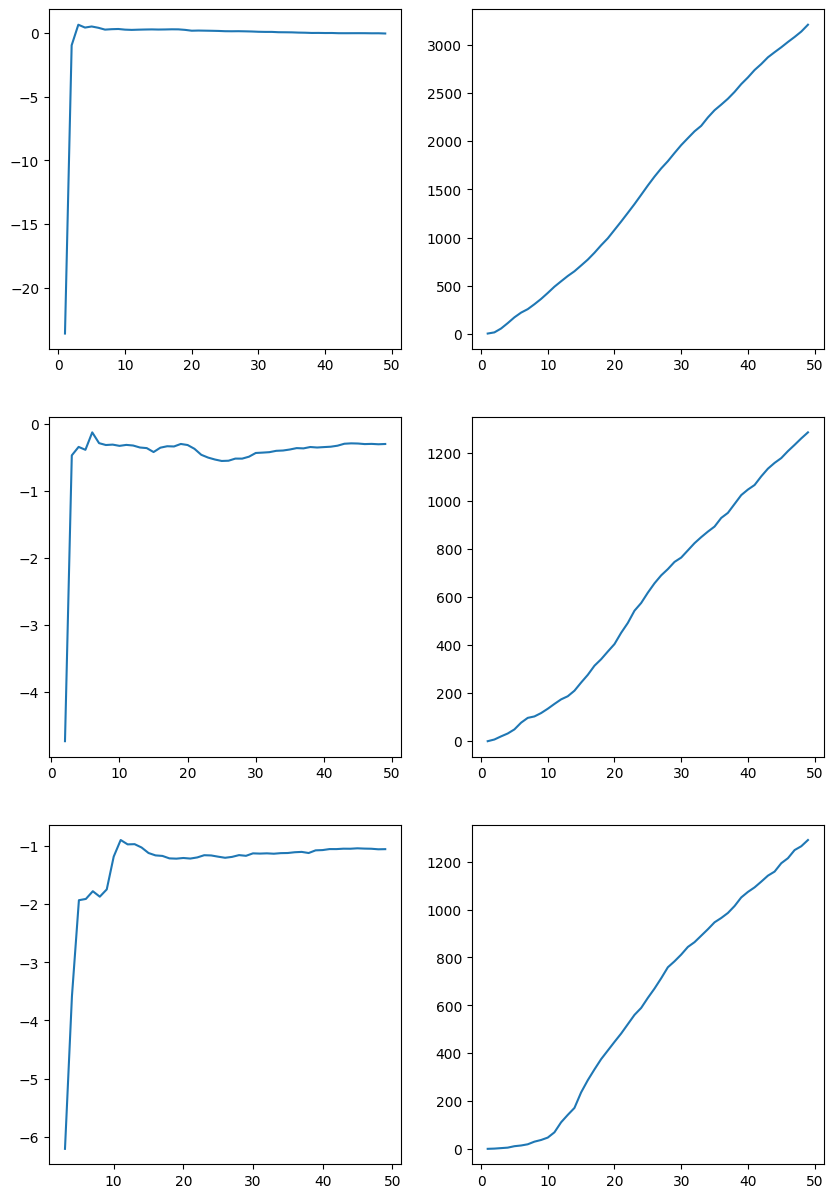

In [72]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [158]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [159]:
close_matches = filter_land_cover(matches[matches.closest_distance < 10])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.76764586].         R squared is : 0.4411741705481603.
The error for coeff = 1 is: 0.19911542818802808.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.16574346].         R squared is : 0.06504882092466568.
The error for coeff = 1 is: -0.3850278743884046.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.00444276].         R squared is : 0.0003372850982684694.
The error for coeff = 1 is: -1.1809920065890869.


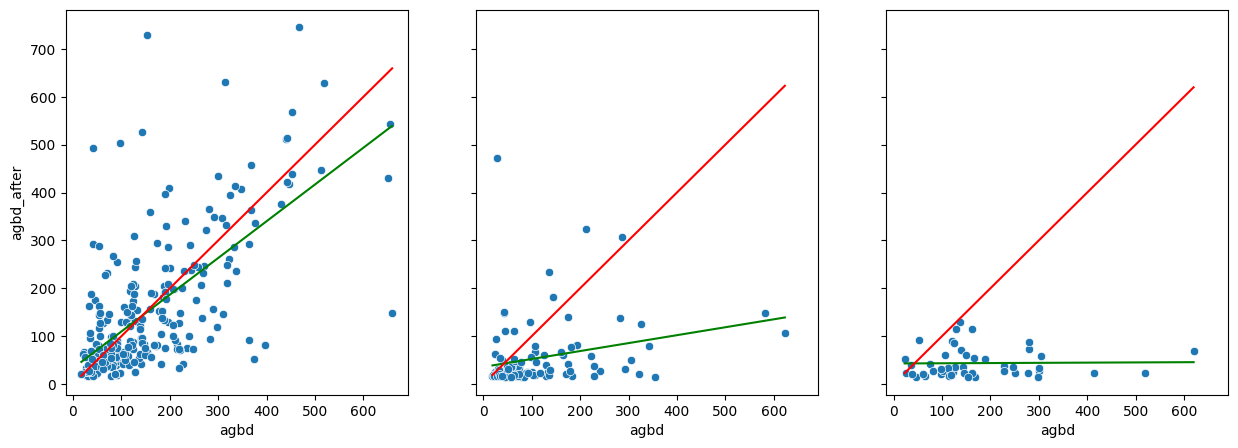

In [144]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

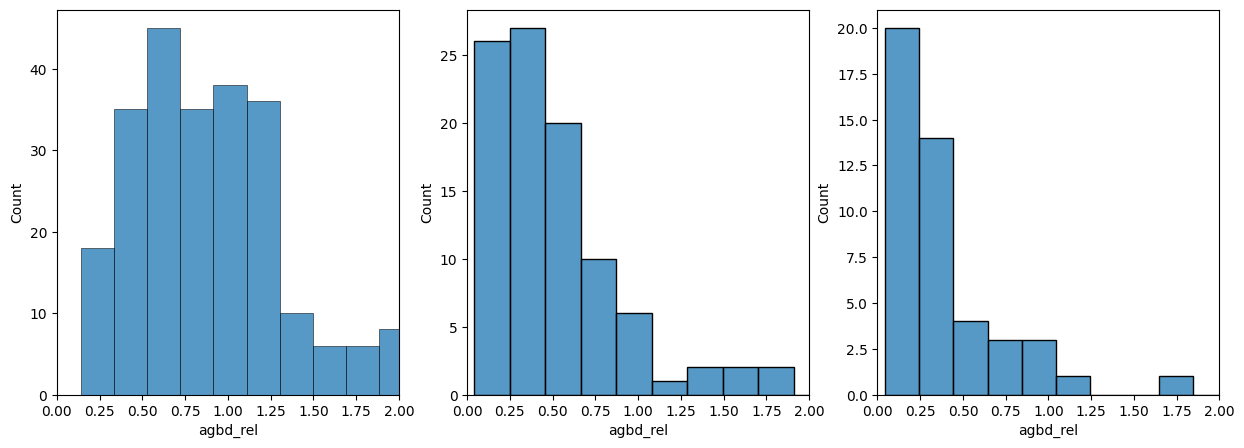

In [143]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

A lot of low severity seems misclassified.

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000108  1986.092702 -3829.762972     inf      0.132034   
lognorm         0.000111  1983.623418 -3828.126575     inf      0.144632   
norm            0.000111  1974.023613 -3833.581790     inf      0.141446   
gamma           0.000120  1954.524668 -3807.513399     inf      0.157948   
burr            0.000642  1774.420676 -3362.631326     inf      0.684160   

             ks_pvalue  
beta      1.919864e-04  
lognorm   3.021378e-05  
norm      4.900797e-05  
gamma     3.553446e-06  
burr     2.183429e-122  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


{'norm': {'loc': 2.6221714383773223, 'scale': 108.48552210144572}}


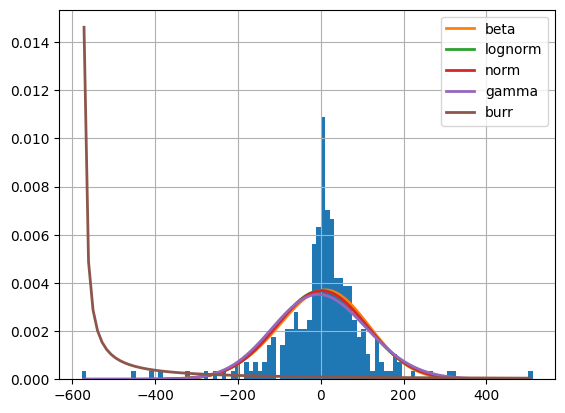

In [125]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000266  1767.008263 -1293.035893     inf      0.167121   
gamma           0.000267  1762.619606 -1297.111658     inf      0.180129   
norm            0.000269  1744.890709 -1300.930152     inf      0.163681   
lognorm         0.000812  1786.937967 -1183.688523     inf      0.794762   
burr            0.000874  1751.699845 -1171.540699     inf      0.709107   

            ks_pvalue  
beta     5.857730e-03  
gamma    2.285866e-03  
norm     7.423164e-03  
lognorm  1.566999e-69  
burr     3.339677e-52  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s]


{'norm': {'loc': 58.31384722391764, 'scale': 112.2860504110404}}


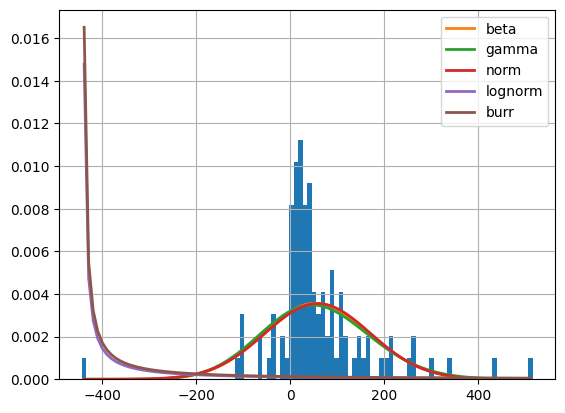

In [111]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]


         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma           0.000464  1398.153034 -530.151665     inf      0.065442   
beta            0.000464  1399.461188 -526.281678     inf      0.065739   
norm            0.000534  1441.930547 -527.378116     inf      0.151840   
lognorm         0.001630  1678.831472 -471.094045     inf      0.699866   
burr            0.001739  1618.662475 -464.218613     inf      0.535917   

            ks_pvalue  
gamma    9.799540e-01  
beta     9.790537e-01  
norm     2.064718e-01  
lognorm  1.342721e-23  
burr     3.806278e-13  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 30.08it/s]


{'norm': {'loc': 129.4534209839841, 'scale': 124.69034455144067}}


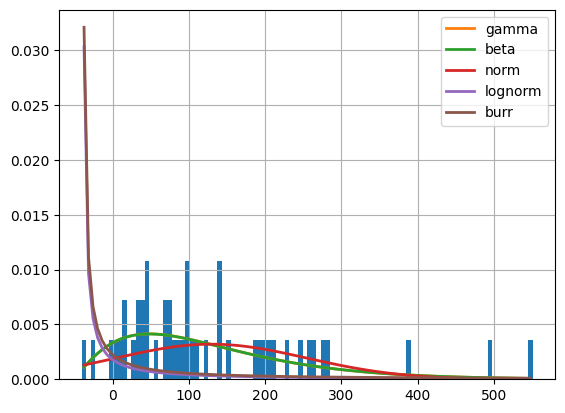

In [112]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

### Stat tests

In [113]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8801906704902649, pvalue=1.7245307558279993e-13)
Ttest results: TtestResult(statistic=0.3904896729450677, pvalue=0.6964930095722461, df=261)
Wilcoxon test results: WilcoxonResult(statistic=14759.0, pvalue=0.04445149416606761)


In [114]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8467029333114624, pvalue=6.995472201509756e-09)
Ttest results: TtestResult(statistic=5.219231680552508, pvalue=9.630272752752117e-07, df=101)
Wilcoxon test results: WilcoxonResult(statistic=773.0, pvalue=6.119563423832334e-10)


In [115]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8745905756950378, pvalue=0.0001224538718815893)
Ttest results: TtestResult(statistic=7.041409835832142, pvalue=7.898174912656163e-09, df=46)
Wilcoxon test results: WilcoxonResult(statistic=19.0, pvalue=4.362732397567015e-12)


## PAI Analysis

In [198]:
matches_l2b = gedi_matching.match_measurements_before_and_after_fire(creek_fire, gedi_burned_l2b, 'pai')

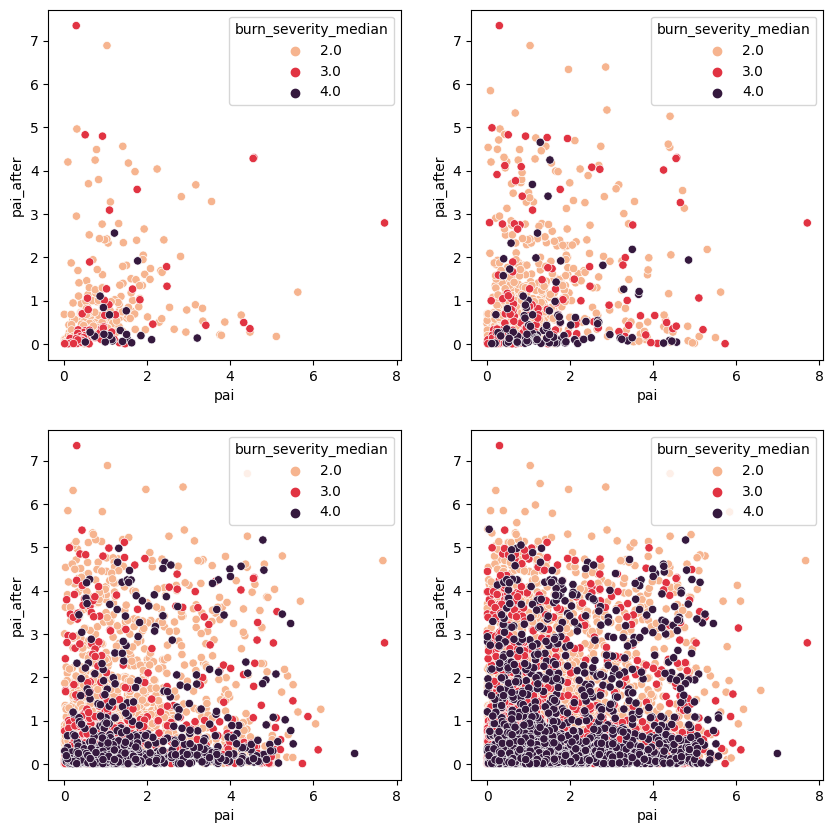

In [151]:
matching_analysis.plot_severity_for_distance(matches_l2b, 'pai')

In [161]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

In [230]:
close_matches = l2b_filter_land_cover(matches_l2b[matches_l2b.closest_distance < 10])

In [231]:
close_matches['date_since'] = ((close_matches.match_datetime - creek_fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.26064344].         R squared is : 0.0453464146843644.
The error for coeff = 1 is: -0.9769288561856893.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.14138853].         R squared is : 0.021233966416471683.
The error for coeff = 1 is: -0.765119073925596.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.01433071].         R squared is : 0.00028793567526719244.
The error for coeff = 1 is: -1.467468289595065.


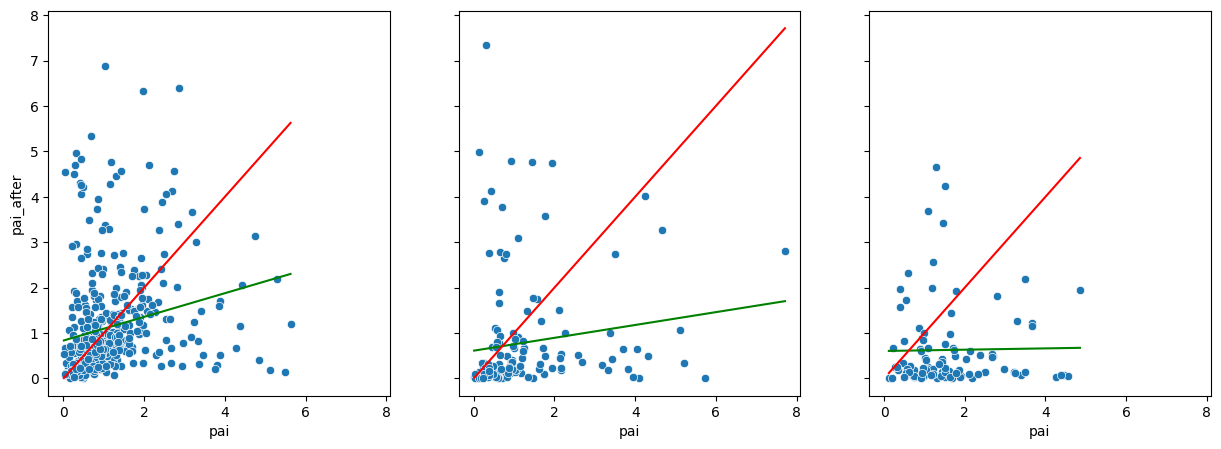

In [232]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'pai')

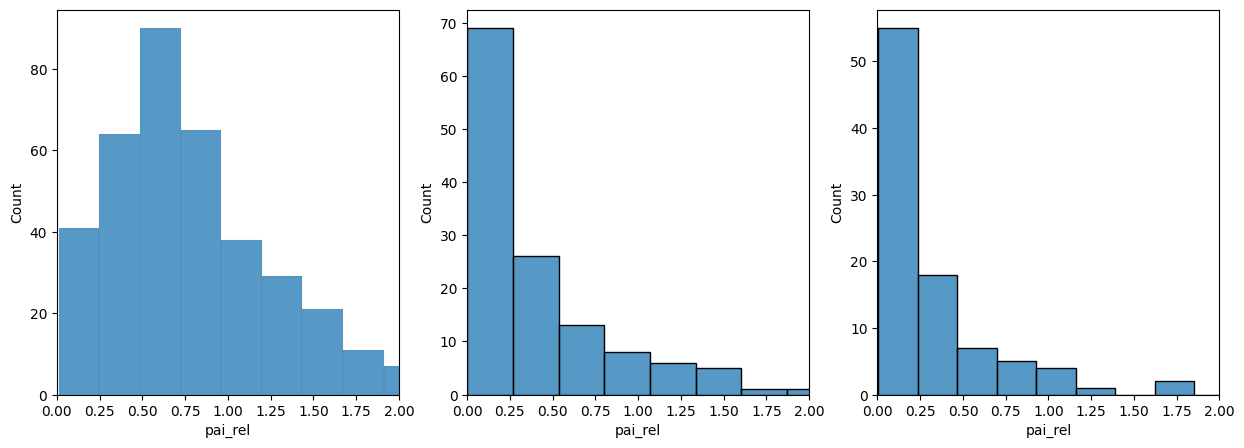

In [233]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


         sumsquare_error         aic          bic  kl_div  ks_statistic  \
burr            0.963359  884.169985 -2620.510141     inf      0.115404   
lognorm         1.633965  858.410020 -2397.810073     inf      0.171704   
norm            1.636974  851.841480 -2403.084177     inf      0.169761   
beta            1.640756  854.284699 -2389.943513     inf      0.169984   
gamma           1.686596  845.196162 -2384.082903     inf      0.175855   

            ks_pvalue  
burr     1.762763e-05  
lognorm  1.243457e-11  
norm     2.227839e-11  
beta     2.084240e-11  
gamma    3.496087e-12  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


{'norm': {'loc': 0.00845029993187066, 'scale': 1.313998752860748}}


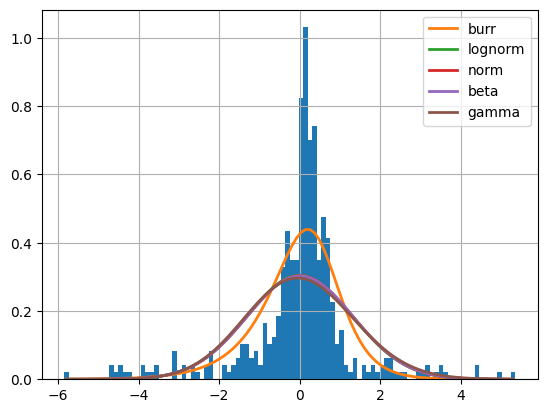

In [235]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
lognorm         1.911757  821.243213 -623.362971     inf      0.213206   
norm            1.915643  813.215483 -628.054903     inf      0.212487   
beta            1.915822  794.872258 -618.060299     inf      0.205147   
gamma           1.949086  822.478347 -620.520318     inf      0.224214   
burr            2.335795  848.485205 -588.924088     inf      0.276140   

            ks_pvalue  
lognorm  2.417344e-06  
norm     2.650848e-06  
beta     6.671478e-06  
gamma    5.657247e-07  
burr     2.120027e-10  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

{'norm': {'loc': 0.42657929061020405, 'scale': 1.6838953210299428}}


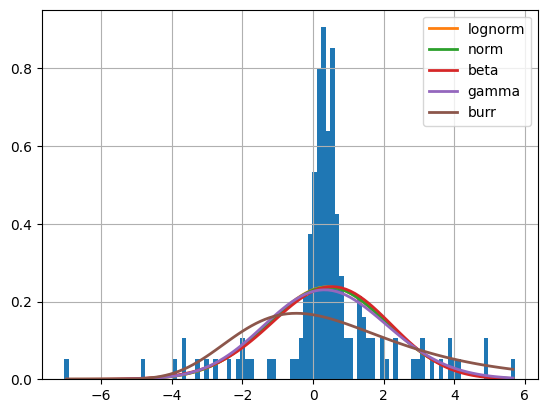

In [236]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
burr            1.728868  545.914557 -397.405720     inf      0.075715   
lognorm         1.918654  531.928044 -391.406671     inf      0.106631   
norm            1.922440  527.606099 -395.830544     inf      0.106691   
beta            1.925960  528.697752 -386.394018     inf      0.104304   
gamma           1.931306  530.736940 -390.736247     inf      0.111065   

         ks_pvalue  
burr      0.576109  
lognorm   0.182837  
norm      0.182354  
beta      0.202411  
gamma     0.149668  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

{'norm': {'loc': 0.9532405669803922, 'scale': 1.3983012650295326}}


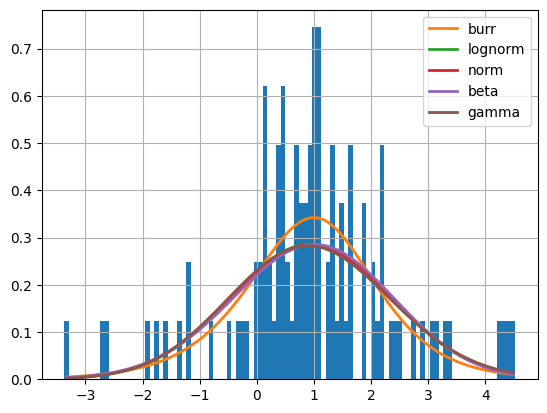

In [237]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'pai')

## PAI Z Analysis

In [276]:
from src.data import pai_vertical
importlib.reload(gedi_matching)
importlib.reload(pai_vertical)

<module 'src.data.pai_vertical' from '/home/jk871/fire-regen/src/data/pai_vertical.py'>

In [277]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_fire(creek_fire, gedi_burned_l2b)

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'fhd_normal', 'pai', 'pai_z', 'pavd_z', 'rh100', 'cover', 'cover_z',
       'beam_type', 'sensitivity', 'gridded_pft_class', 'geometry',
       'burn_severity_2x2', 'burn_severity_mean', 'burn_severity_std',
       'burn_severity_median', 'burn_year_2x2', 'burn_year_mean',
       'burn_year_std', 'burn_year_median', 'burn_counts_2x2',
       'burn_counts_mean', 'burn_counts_std', 'burn_counts_median',
       'land_cover_2x2', 'land_cover_mean', 'land_cover_std',
       'land_cover_median', 'gedi_year', 'gedi_month', 'time_since_burn',
       'index_right', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'Shape_Length',
       'Shape_Area', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'FID', 'pai_z_np',
       'pai_z_padded', 'pai_z_delta_np'],
      dtype='object')
1
2
3


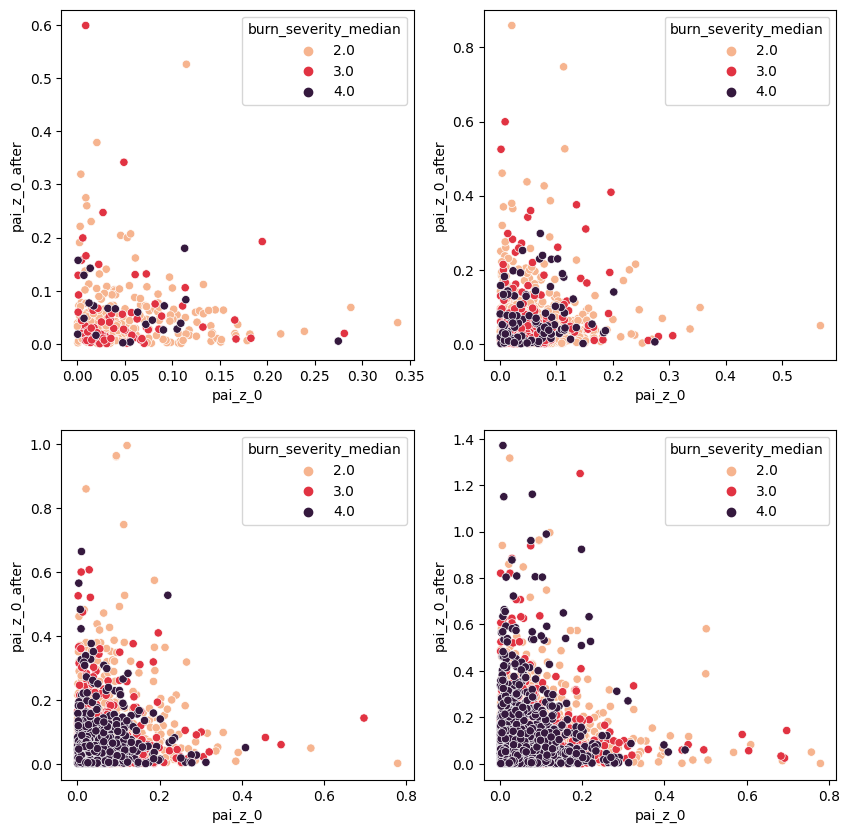

In [254]:
matching_analysis.plot_severity_for_distance(matches_paiz, 'pai_z_0')

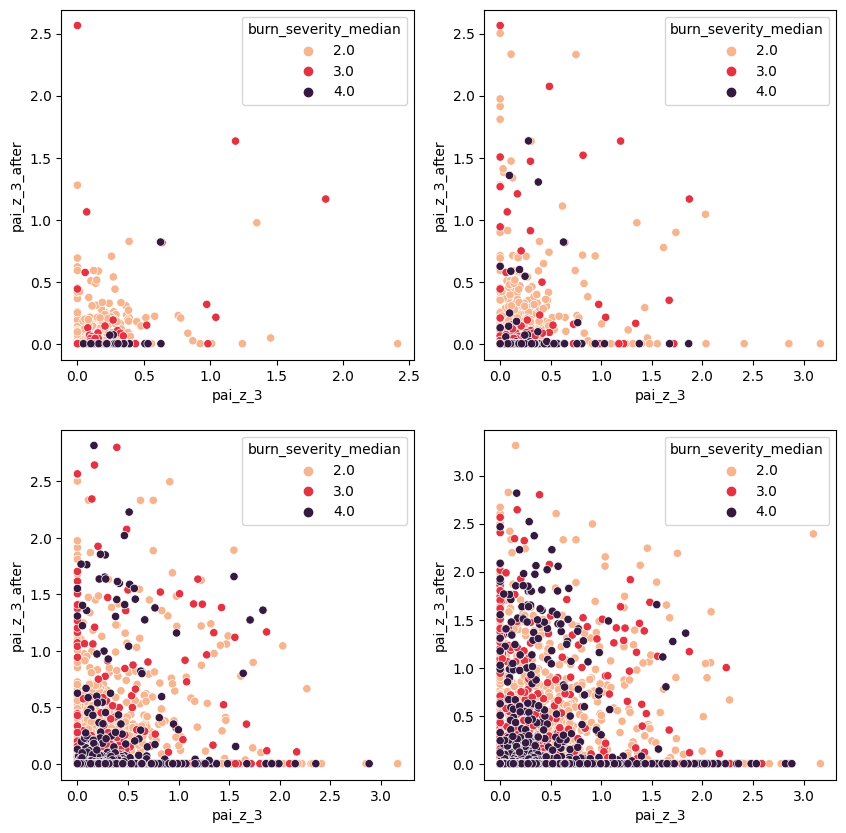

In [261]:
matching_analysis.plot_severity_for_distance(matches_paiz, 'pai_z_3')

In [278]:
close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 10])

In [322]:
def get_pai_z_df(df, severity):
    lala = get_severity(close_matches, severity).pai_z_delta_diff.to_numpy()
    new_lala = np.empty((lala.shape[0], lala[0].shape[0]))

    for i in range(lala.shape[0]):
        new_lala[i] = lala[i]

    return pd.melt(pd.DataFrame(new_lala))

(0.0, 13.0)

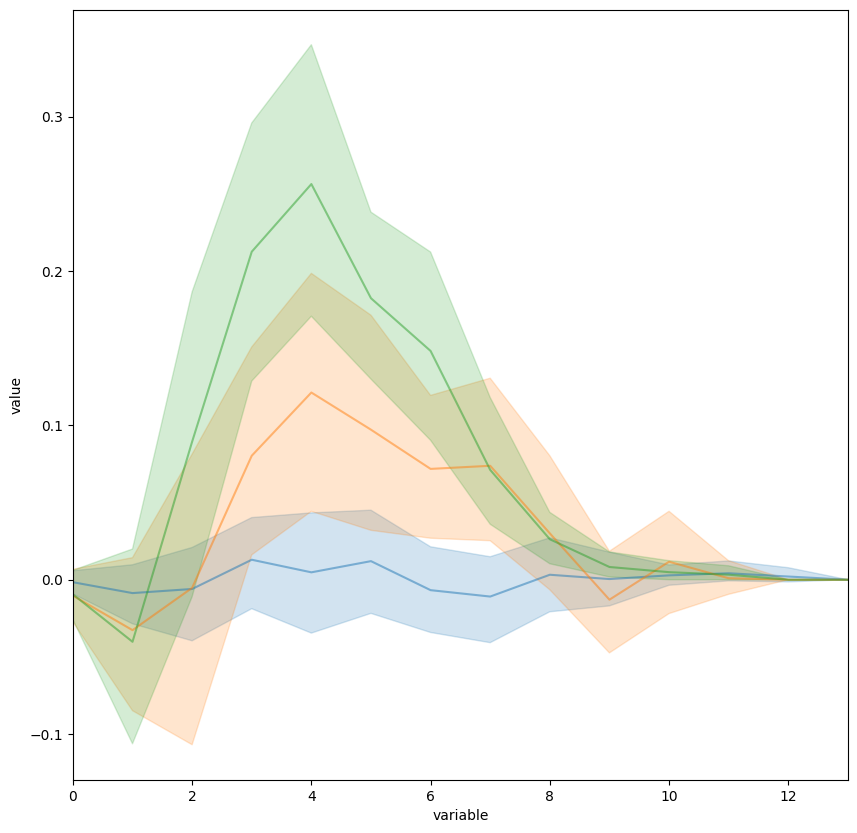

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(get_pai_z_df(close_matches, 2), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 3), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 4), x='variable', y='value', ax=ax, alpha=0.5)
ax.set_xlim((0, 13))

In [296]:
pd.DataFrame(get_severity(close_matches, 2).pai_z_delta_diff.to_numpy(), columns=range(30))

ValueError: Shape of passed values is (433, 1), indices imply (433, 30)

In [290]:
low_paiz_diff = np.mean(get_severity(close_matches, 2).pai_z_delta_diff.to_numpy(), axis=0)
medium_paiz_diff = np.mean(get_severity(close_matches, 3).pai_z_delta_diff.to_numpy(), axis=0)
high_paiz_diff = np.mean(get_severity(close_matches, 4).pai_z_delta_diff.to_numpy(), axis=0)

(0.0, 13.0)

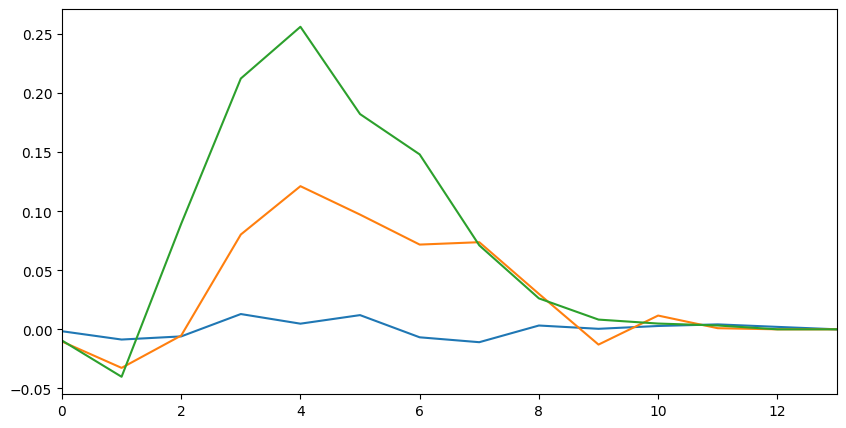

In [291]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(low_paiz_diff, ax=ax)
sns.lineplot(medium_paiz_diff, ax=ax)
sns.lineplot(high_paiz_diff, ax=ax)
ax.set_xlim((0, 13))

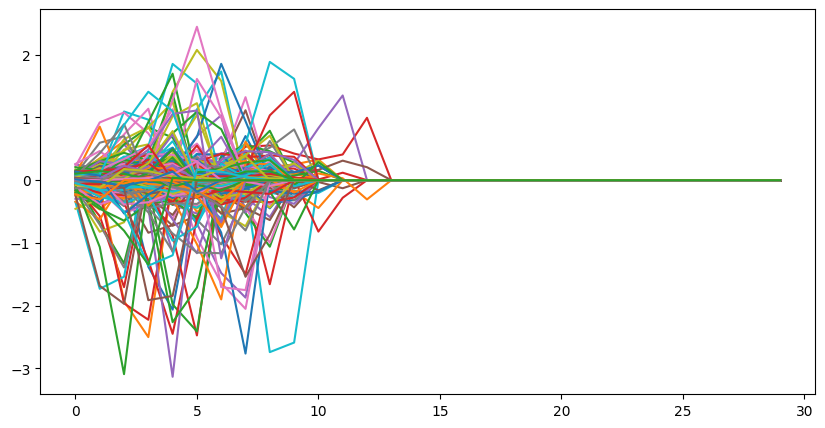

In [287]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(get_severity(close_matches, 2).shape[0]):
    sns.lineplot(get_severity(close_matches, 2).iloc[i].pai_z_delta_diff, ax=ax)

ax.set_xlim((0, 13))

In [256]:
close_matches['date_since'] = ((close_matches.match_datetime - creek_fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

Linear regression fit for severity 2.
Best Linear regression coefficient is [-0.03010639].         R squared is : 0.0005594907146140304.
The error for coeff = 1 is: -1.6814808495327664.
Linear regression fit for severity 3.
Best Linear regression coefficient is [-0.1295127].         R squared is : 0.005140290036326545.
The error for coeff = 1 is: -3.5664097442912865.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.09258702].         R squared is : 0.004718911492058275.
The error for coeff = 1 is: -1.6669987889437814.


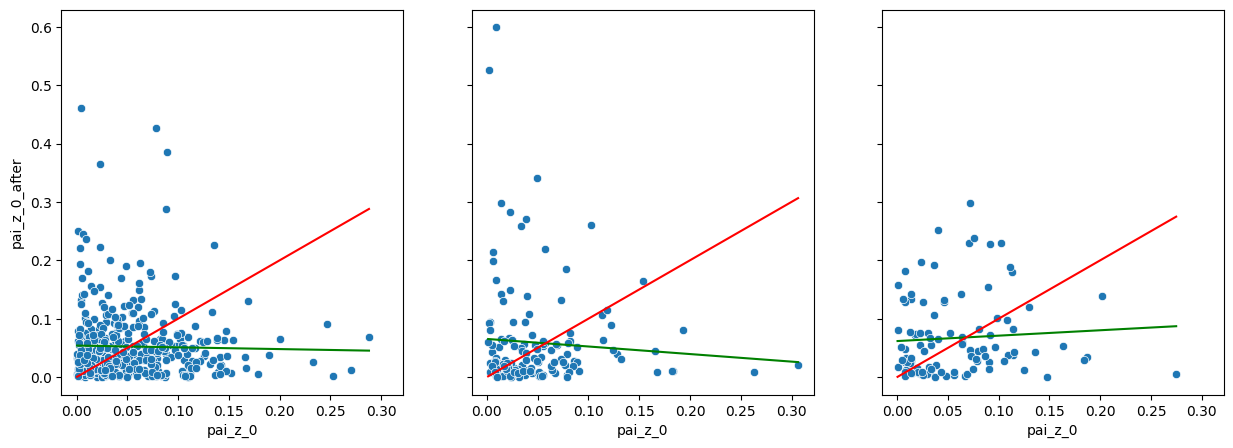

In [257]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'pai_z_0')

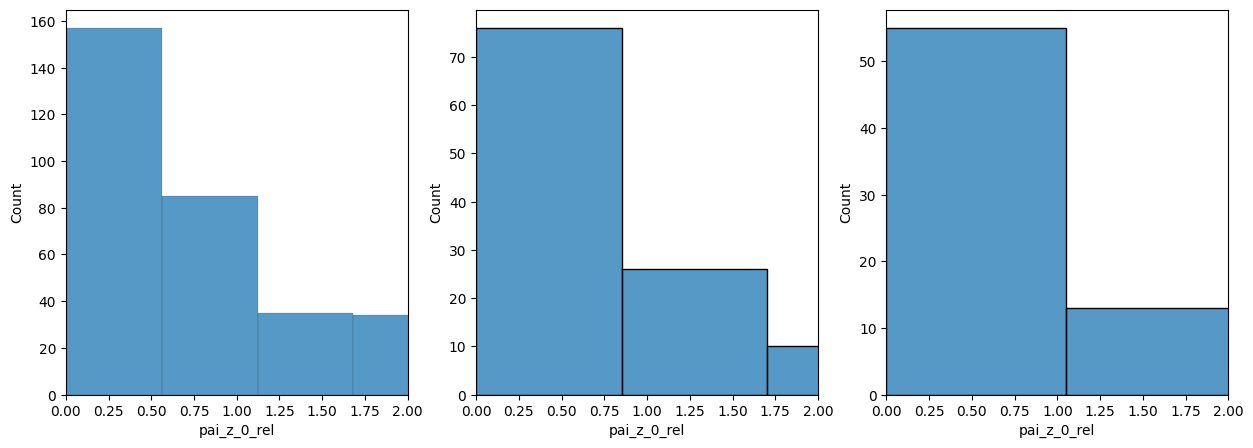

In [258]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'pai_z_0')

In [ ]:
delta_low = np.mean(pai_vertical.transform_pai_z(matches_l2b).pai_z_delta_np.to_numpy(), axis=0)

In [249]:
koko = pai_vertical.transform_pai_z(matches_l2b)

In [250]:
koko.columns

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'fhd_normal', 'pai', 'pai_z', 'pavd_z', 'rh100', 'cover', 'cover_z',
       'beam_type', 'sensitivity', 'gridded_pft_class', 'geometry',
       'burn_severity_2x2', 'burn_severity_mean', 'burn_severity_std',
       'burn_severity_median', 'burn_year_2x2', 'burn_year_mean',
       'burn_year_std', 'burn_year_median', 'burn_counts_2x2',
       'burn_counts_mean', 'burn_counts_std', 'burn_counts_median',
       'land_cover_2x2', 'land_cover_mean', 'land_cover_std',
       'land_cover_median', 'gedi_year', 'gedi_month', 'time_since_burn',
       'index_right', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'Shape_Length',
       'Shape_Area', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'FID', 'pai_after',
       'closest_distance', 'pai_diff', 'pai_rel', 'match_datetime',
       '

In [251]:
koko[['pai_z_delta_np', 'pai_z_1']]

,pai_z_delta_np,pai_z_1
222136,"[0.08615741, 0.12871812, 0.0, 0.0, 0.0, 0.0, 0...",0.128718
222144,"[0.03465385, 0.09109304, 0.14440398, 0.0918610...",0.091093
222150,"[0.02450353, 0.12975491, 0.08796539, 0.0902101...",0.129755
222154,"[0.055725653, 0.127392707, 0.11860151, 0.02941...",0.127393
222156,"[0.031225359, 0.11153413099999998, 0.073747840...",0.111534
...,...,...
27386825,"[0.03870791, 0.11150560999999999, 0.29805546, ...",0.111506
27386826,"[0.013223599, 0.21036381099999998, 0.24631373,...",0.210364
27386827,"[0.0007135503, 0.2550893497, 0.335320699999999...",0.255089
27386829,"[0.06367224, 0.39110962, 0.40752891, 0.9785258...",0.391110


In [243]:
np.mean(koko.pai_z_delta_np.to_numpy(), axis=0)

array([5.15223809e-02, 1.76687967e-01, 2.36091250e-01, 2.26746476e-01,
       1.85778011e-01, 1.37850223e-01, 9.85330137e-02, 6.36905326e-02,
       3.66867113e-02, 1.89593564e-02, 7.31995960e-03, 2.16479703e-03,
       7.76151922e-04, 5.61483241e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [263]:
koko.pai_z_delta_np - koko.pai_z_delta_np

222136      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
222144      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
222150      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
222154      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
222156      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                  ...                        
27386825    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
27386826    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
27386827    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
27386829    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
27386830    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: pai_z_delta_np, Length: 22645, dtype: object